In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
# problem = "Pendulum-v1"
# env = gym.make(problem)

# num_states = env.observation_space.shape[0]
# print("Size of State Space ->  {}".format(num_states))
# num_actions = env.action_space.shape[0]
# print("Size of Action Space ->  {}".format(num_actions))

# upper_bound = env.action_space.high[0]
# lower_bound = env.action_space.low[0]

# print("Max Value of Action ->  {}".format(upper_bound))
# print("Min Value of Action ->  {}".format(lower_bound))

2022-09-12 07:07:48.494320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-12 07:07:48.494365: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.8/dist-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/usr/local/lib/python3.8/dist-packages/keras/utils/image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/usr/local/lib/python3.8/dist-packages/keras/utils/image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampl

In [2]:
### Setup the environment

num_states=3 # Considering z pos, z vel, z acc

num_actions=1 # just controling v_z

mass=0.67 #in kg

g=9.81

upper_bound= mass*g # i.e. CTW=2

lower_bound= -mass * g # we cannot do better without upside-down

output_length=12

vel_reward_weight_factor=0.1

# lib_interface stuff
import glob
import ctypes
import math

libfile = glob.glob('../Sim_intfc/out/build/linux-default/libinterface_simulink.so')[0]
mylib = ctypes.CDLL(libfile)

class EnvUAV_cmd_z:
    simulink_input_length=4
    simulink_states_length=12
    print_period=1 #in seconds
    episode_timeout=7.0 #in seconds
    terminal_states=[1.0,0,0]
    termination_causes={'reached_goal':0,'time_out':1,'nan_error':2}
    def __init__(self,simulation_dt,sampling_dt,termination_cost,mass=1,CTW=2,g=9.81):
        mylib.LoadModel()
        mylib.run_a_step.restype = np.ctypeslib.ndpointer(dtype=np.float64,shape=(self.simulink_states_length,))
        mylib.run_a_step.argtypes = [np.ctypeslib.ndpointer(dtype=np.float64),ctypes.c_int]
        #self.mass=mass
        #self.CTW=CTW
        #self.g=g

        self.simulation_dt=simulation_dt
        self.sampling_dt=sampling_dt
        self.sim_steps_per_samp_period=round(self.sampling_dt/self.simulation_dt) # Note sim dt must not be larger than sampling dt

        self.steps_per_print_period=int(EnvUAV_cmd_z.print_period/self.sampling_dt)
        self.sampling_step_counter=0
        self.reset()
    
    def __call__(self,input):
        self.sampling_step_counter=self.sampling_step_counter+1
        inputs = np.zeros(EnvUAV_cmd_z.simulink_input_length,dtype=np.float64)
        inputs[0]=0.0
        inputs[1]=0.0
        inputs[2]=0.0
        inputs[3]=np.copy(input[0])
        for i in range(self.sim_steps_per_samp_period):
            self.states_meas = mylib.run_a_step(inputs,len(inputs))
            
        self.z_states_meas[0]=np.copy(self.states_meas[2])-EnvUAV_cmd_z.terminal_states[0]
        self.z_states_meas[1]=np.copy(self.states_meas[5])-EnvUAV_cmd_z.terminal_states[1]
        if num_states>2:
            self.z_states_meas[2]=np.copy(self.states_meas[8])-EnvUAV_cmd_z.terminal_states[2]
        #cost=np.linalg.norm(np.array([self.z_states_meas[0],self.z_states_meas[1],self.z_states_meas[2]]))
        cost=np.linalg.norm(np.array([self.z_states_meas[0],vel_reward_weight_factor*self.z_states_meas[1]]))
        self.reward=-cost*self.sampling_dt*100 # By 100 to scale up reward for training
        if en_goal_termination==True:    
            if (cost<termination_cost):
                self.termination_cause=EnvUAV_cmd_z.termination_causes['reached_goal']
                print('Reached Goal!')
                self.done=True
            
        if (self.sampling_step_counter*self.sampling_dt>EnvUAV_cmd_z.episode_timeout):
            self.termination_cause=EnvUAV_cmd_z.termination_causes['time_out']
            self.done=True
        
        if (math.isnan(self.z_states_meas[0]) or math.isnan(self.z_states_meas[1])):
            self.z_states_meas=[0,0,0] # This is incorrect, but hopefully it is waived by stochastic learning
            self.reward=np.ones(1)*0.0
            self.termination_cause=EnvUAV_cmd_z.termination_causes['nan_error']
            print('Warning NaN termination')
            self.done=True
        
        return self.z_states_meas, self.reward, self.done, self.termination_cause

    def reset(self):
        if self.sampling_step_counter>0:
            mylib.TermModel()
        self.sampling_step_counter=0
        mylib.LoadModel()
        mylib.InitModel()
        initial_states=np.zeros(num_states)
        self.done=False
        self.z_states_meas=np.zeros(num_states)
        #self.termination_cause=list(EnvUAV_cmd_z.termination_causes.keys())[0]
        self.termination_cause=EnvUAV_cmd_z.termination_causes['reached_goal']
        return initial_states

    def print_states_periodic(self):
        if self.sampling_step_counter % self.steps_per_print_period ==1:
            print('z pos: ' + str(self.states_meas[2]))
            print('z vel: ' + str(self.states_meas[5]))
            print('simulation time (s): ' + str(self.sampling_step_counter*self.sampling_dt))
            print('===================')

termination_cost=0.5 # e.g. 0.05 is 5cm , 5cm/s , 5cm/s^2
simulink_dt=0.0005
sampling_dt=0.005

UAV_alt_ctrl=EnvUAV_cmd_z(simulink_dt,sampling_dt,termination_cost)



** starting the model **

** starting the model **


In [3]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

### Define Actor-Critic

In [5]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [6]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

### Hyperparameters

In [7]:




# RL models
actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 300
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 1024)

# nosie model
init_std_dev = 0.4
final_exponent_val=10 #formula std_dev=init_std_dev * exp^(-(ep/total_episodes)*final_exponent_val)
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(init_std_dev) * np.ones(1))
en_noise_decay=False

# model behaviour
en_goal_termination=False


2022-09-12 07:07:50.874995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-12 07:07:50.875035: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-12 07:07:50.875052: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-NRRPHG8V): /proc/driver/nvidia/version does not exist
2022-09-12 07:07:50.875267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train


** starting the model **
Episode * 0 * Avg Reward is ==> -637.7485275958369
Episode * 0 * Reward is ==> -637.7485275958369

** starting the model **
Episode * 1 * Avg Reward is ==> -3041.6084414855186
Episode * 1 * Reward is ==> -5445.4683553752

** starting the model **
Episode * 2 * Avg Reward is ==> -2881.75132261159
Episode * 2 * Reward is ==> -2562.0370848637317

** starting the model **
Episode * 3 * Avg Reward is ==> -2264.3686476131256
Episode * 3 * Reward is ==> -412.2206226177329

** starting the model **
Episode * 4 * Avg Reward is ==> -1931.8020757817467
Episode * 4 * Reward is ==> -601.5357884562317

** starting the model **
Episode * 5 * Avg Reward is ==> -1733.1189531747816
Episode * 5 * Reward is ==> -739.7033401399563

** starting the model **
Episode * 6 * Avg Reward is ==> -1695.0053532400564
Episode * 6 * Reward is ==> -1466.323753631704

** starting the model **
Episode * 7 * Avg Reward is ==> -2804.8520888761714
Episode * 7 * Reward is ==> -10573.779238328976

**

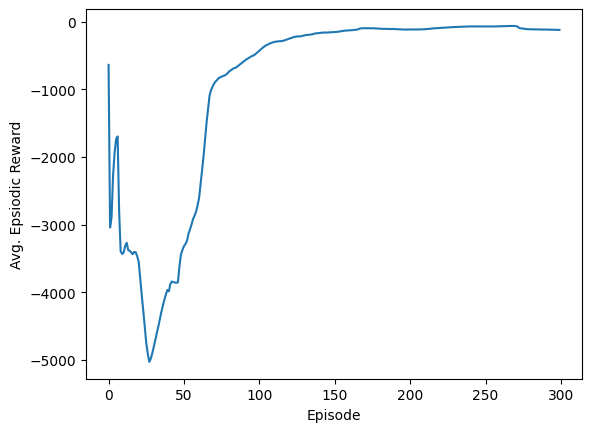

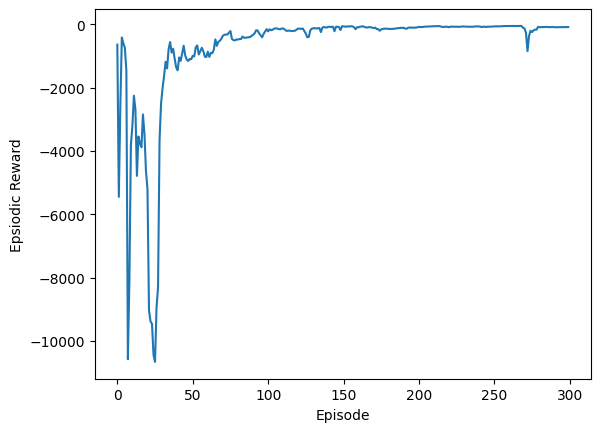

In [8]:
# To store reward history of each episode
ep_reward_list = []

# To store average reward history of last few episodes
avg_reward_list = []

# To store final states of the system
final_states_reward_list = []  # [states, reward]

# To store termiantion status
termination_causes_list=[]

# To store all state_action pairs
states_action_list=[]
states_action_lists=[]

learning_frequency=128 #e.g. 4 times for every buffer batch

# Takes about 4 min to train
for ep in range(total_episodes):

    #prev_state = env.reset()
    prev_state = UAV_alt_ctrl.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        #state, reward, done, info = env.step(action)
        state, reward, done, termination_cause=UAV_alt_ctrl(action)
        states_action_list.append([state.copy(),action[0].copy()])
        #UAV_alt_ctrl.print_states_periodic()

        buffer.record((prev_state.copy(), action.copy(), reward.copy(), state.copy()))
        episodic_reward += reward

        if buffer.buffer_counter>buffer.batch_size:
            if (buffer.buffer_counter%(int(buffer.batch_size/learning_frequency))==1):
                buffer.learn()
                update_target(target_actor.variables, actor_model.variables, tau)
                update_target(target_critic.variables, critic_model.variables, tau)


        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)

    ep_reward_list.append(episodic_reward)
    termination_causes_list.append(termination_cause)
    final_states_reward_list.append([state.copy(),reward.copy()])
    states_action_lists.append(states_action_list.copy())
    states_action_list.clear()

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    print("Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
    
    avg_reward_list.append(avg_reward)
    if en_noise_decay:
        ou_noise.std_dev[0]=init_std_dev * math.exp(-(ep/total_episodes)*final_exponent_val)



### Plotting

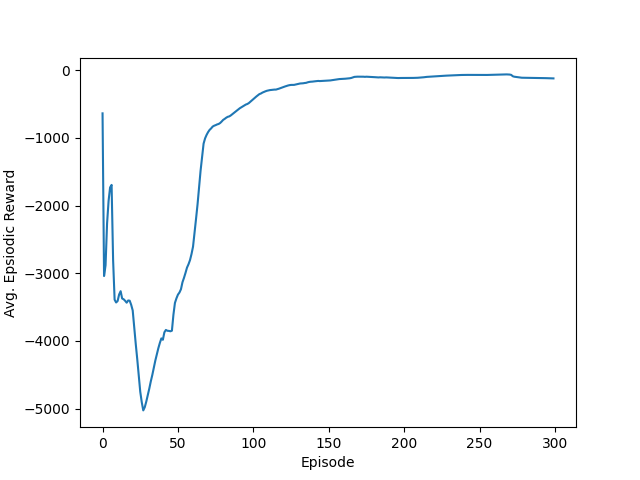

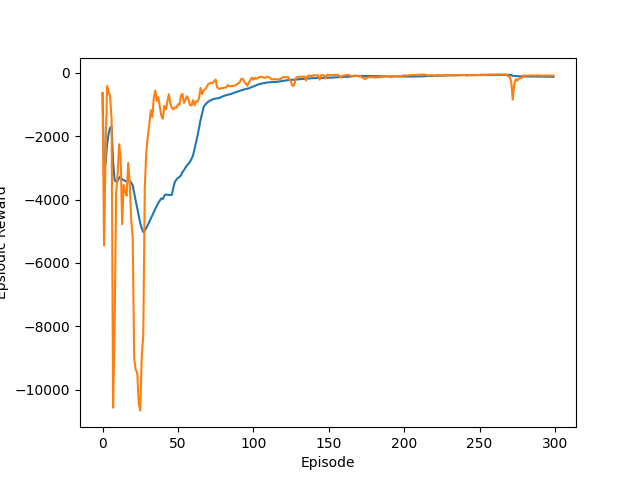

In [28]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.close()

plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Epsiodic Reward")
plt.show()


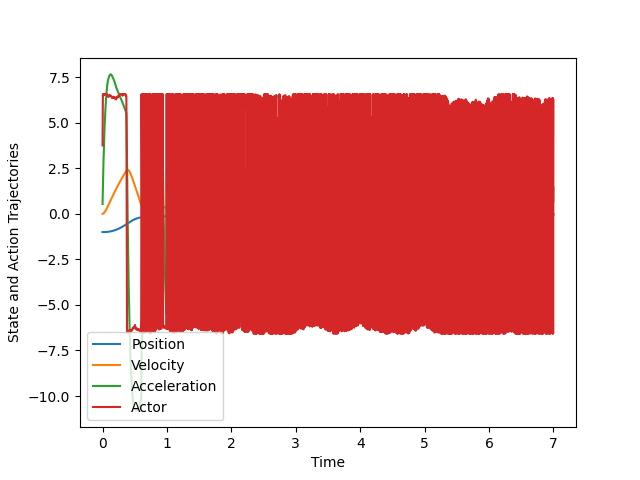

In [35]:
# Plotting states
index_of_episode=299

pos_vals=[]
vel_vals=[]
acc_vals=[]
act_vals=[]

time_vals=np.linspace(0,EnvUAV_cmd_z.episode_timeout,len(states_action_lists[index_of_episode]))

for tuble in states_action_lists[index_of_episode]:
    pos_vals.append(tuble[0][0])
    vel_vals.append(tuble[0][1])
    acc_vals.append(tuble[0][2])
    act_vals.append(tuble[1])

plt.close()
plt.plot(time_vals,pos_vals)
plt.plot(time_vals,vel_vals)
plt.plot(time_vals,acc_vals)
plt.plot(time_vals,act_vals)

plt.xlabel("Time")
plt.ylabel("State and Action Trajectories")
plt.legend(['Position','Velocity','Acceleration','Actor'])
plt.show()

In [9]:
# Plotting of value function
%matplotlib widget
from random import sample
from tabnanny import verbose
from mpl_toolkits.mplot3d import Axes3D

import pickle
import csv

## Inquiry actor
# Mesh initiation
samples_per_dim=20

pos_range=[-100,100]
vel_range=[-100,100]
acc_range=[-5,5]

pos_states=np.linspace(pos_range[0],pos_range[1],samples_per_dim)

vel_states=np.linspace(vel_range[0],vel_range[1],samples_per_dim)

acc_states=np.linspace(acc_range[0],acc_range[1],samples_per_dim)

value_function=np.linspace((pos_range[0],vel_range[0]),(pos_range[1],vel_range[1]),samples_per_dim)

actor_output=np.zeros([samples_per_dim,samples_per_dim,samples_per_dim])

value_function=np.ones([samples_per_dim,samples_per_dim,samples_per_dim])

default_acc_state=acc_states[-1]

for i in range(samples_per_dim):
    for j in range(samples_per_dim):
        #for k in range(samples_per_dim):
        input_to_actor=np.asarray([pos_states[i],vel_states[j],default_acc_state])
        input_to_actor=input_to_actor.reshape(1,3)
        actor_output[i,j,0]=actor_model.predict(input_to_actor,verbose=0)


for i in range(samples_per_dim):
    for j in range(samples_per_dim):
        #for k in range(samples_per_dim):
        input_to_critic_states=np.asarray([pos_states[i],vel_states[j],default_acc_state])
        input_to_critic_states=input_to_critic_states.reshape(1,3)
        input_to_critic_action=np.asarray([actor_output[i,j,0]])
        value_function[i,j,0]=critic_model([input_to_critic_states,input_to_critic_action])
            




/home/mchehadeh_ubuntu/.local/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/tmp/ipykernel_22122/2847107766.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


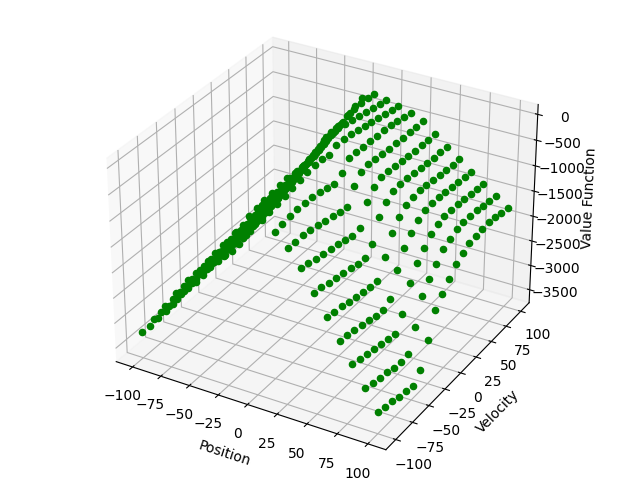

In [29]:
# creating figure
fig = plt.figure()
ax = Axes3D(fig)
  
with open('value_function.csv','w') as f:
    write = csv.writer(f)
    for i in range(samples_per_dim):
        for j in range(samples_per_dim):
            ax.scatter(pos_states[i], vel_states[j], value_function[i,j,0], color='green')
            #write_list=[pos_states[i],vel_states[j],value_function[i,j,0]]
            #write.writerows(write_list)


  
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('Value Function')
  
# displaying the plot
plt.show()

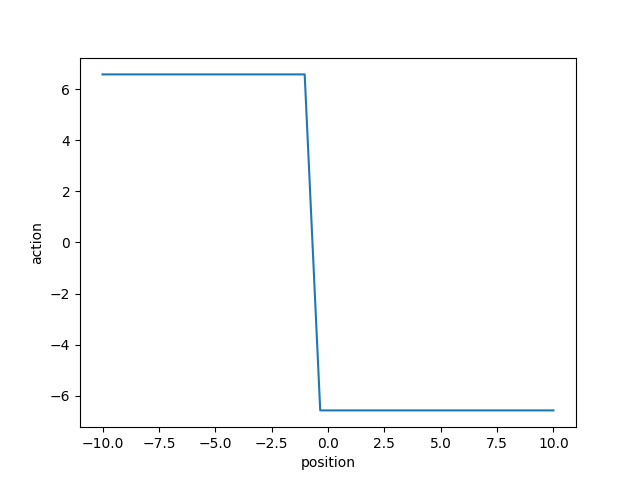

In [36]:
# Plotting actor output

forced_acc_state=0.0
num_pts=30

actor_output=np.zeros(num_pts)

# fix velocity and vary position
forced_velocity=0.0
ranged_position=np.linspace(-10,10,num_pts)

for i in range(num_pts):
    input_to_actor=np.asarray([ranged_position[i],forced_velocity,forced_acc_state])
    input_to_actor=input_to_actor.reshape(1,3)
    actor_output[i]=actor_model.predict(input_to_actor,verbose=0)

plt.close()
plt.plot(ranged_position,actor_output)
plt.xlabel("position")
plt.ylabel("action")
plt.show()


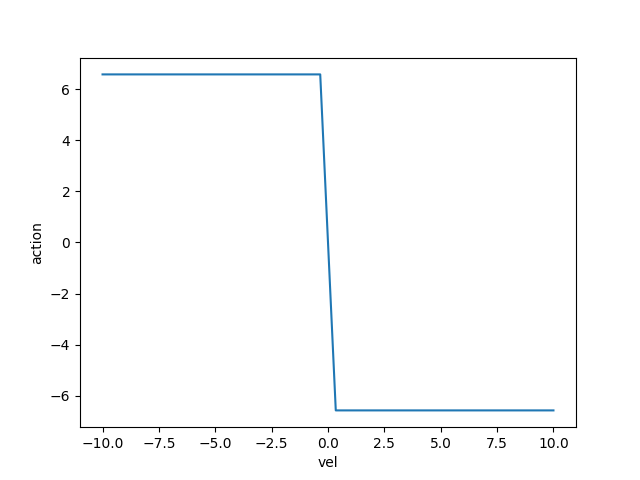

In [37]:
# fix position and vary velocity
forced_position=0.0
ranged_vel=np.linspace(-10,10,num_pts)

for i in range(num_pts):
    input_to_actor=np.asarray([forced_position,ranged_vel[i],forced_acc_state])
    input_to_actor=input_to_actor.reshape(1,3)
    actor_output[i]=actor_model.predict(input_to_actor,verbose=0)

plt.close()
plt.plot(ranged_vel,actor_output)
plt.xlabel("vel")
plt.ylabel("action")
plt.show()

### Save

In [ ]:
# Prepared data for save in csv
import pickle
import csv

index_of_episode=199
flat_list=[]

for tuble in states_action_lists[index_of_episode]:
    flat_list.append([tuble[0].tolist()+[tuble[1].tolist()]][0])

with open('episode_trajectories.csv','w') as f:
    write = csv.writer(f)
    write.writerows(flat_list)


In [ ]:
# Save the weights
actor_model.save_weights("uav_z_u_cmd_actor.h5")
critic_model.save_weights("uav_z_u_cmd_critic.h5")

target_actor.save_weights("uav_z_u_cmd_target_actor.h5")
target_critic.save_weights("uav_z_u_cmd_target_critic.h5")

In [ ]:
print(states_action_lists[4][3])